In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import datetime
from scipy import signal
from misc_functions import yearsago
from dateutil.relativedelta import relativedelta
from scipy import fftpack

%matplotlib inline

In [14]:
with open("date_list.pkl", "rb") as f:
    date_list = pickle.load(f)
datetime_list = [datetime.datetime.combine(d, datetime.time.min) for d in date_list]
datetime_list = sorted(datetime_list)

dcounts = Counter(d for d in datetime_list)
date_list, count_list = [], []
for d, count in dcounts.items():
    date_list.append(d)
    count_list.append(count)
    
#Monday is 0 and Sunday is 6
day_of_week_list = [d.weekday() for d in date_list]

#Grouping by day of the week
slice_indx_lst = []
old_day_indx = -1 #Throwaway negative number
for i, day_indx in enumerate(day_of_week_list):
    if old_day_indx >= day_indx:
        slice_indx_lst.append(i)
    old_day_indx = day_indx
slice_indx_lst.append(len(date_list))
slice_indx_lst.insert(0, 0)
sliced_days, sliced_dates, sliced_counts = [], [], []
for i, j in zip(slice_indx_lst[:-1], slice_indx_lst[1:]):
    sliced_days.append(day_of_week_list[i:j])
    sliced_dates.append(date_list[i:j])
    sliced_counts.append(count_list[i:j])

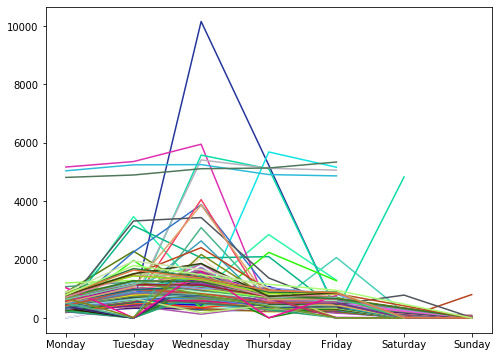

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
for days, counts in zip(sliced_days, sliced_counts):
    
    #Inserting zeros anytime there is a blank entry and changing blank entry to contain consecutive day
    ax.plot(days, counts, c=np.random.rand(3,))

ax.set_xticklabels([' ', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.savefig("Agregated_By_Week.pdf")


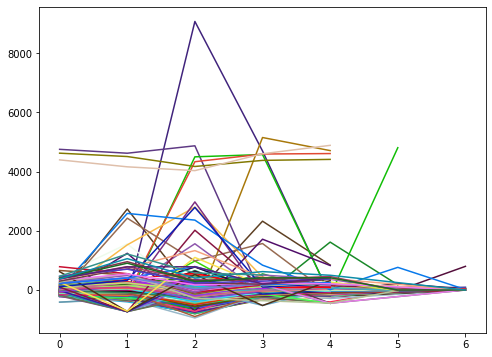

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

all_day_list = [0, 1, 2, 3, 4, 5, 6]
all_day_count = [0, 0, 0, 0, 0, 0, 0] 
for days, counts in zip(sliced_days, sliced_counts):
    for day, count in zip(days, counts):
        all_day_count[day] += count

all_day_count = [i / len(sliced_counts) for i in all_day_count]

detrended_sliced_counts = []
for days, counts in zip(sliced_days, sliced_counts):
    new_count_list = []
    for day, count in zip(days, counts):
        new_count = count - all_day_count[day]
        new_count_list.append(new_count)
    detrended_sliced_counts.append(new_count_list)

for days, counts in zip(sliced_days, detrended_sliced_counts):
    ax.plot(days, counts, c=np.random.rand(3,))


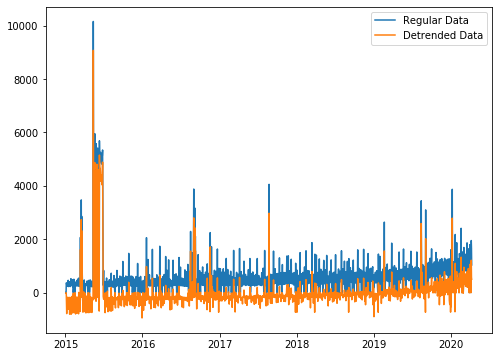

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
detrended_count_list = [item for sublist in detrended_sliced_counts for item in sublist]
ax.plot(date_list, count_list, label='Regular Data')
ax.plot(date_list, detrended_count_list, label='Detrended Data')
plt.legend()


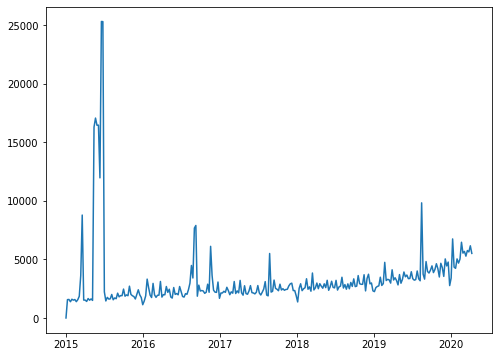

In [36]:
#weekly sums
fig, ax = plt.subplots(figsize=(8,6))
sumed_week_list = [sum(sliced) for sliced in sliced_counts]
num_weeks = [date_list[0] +  datetime.timedelta(weeks=i) for i in range(len(sliced_counts))]
ax.plot(num_weeks, sumed_week_list)
plt.savefig("Summed_By_Week.pdf")



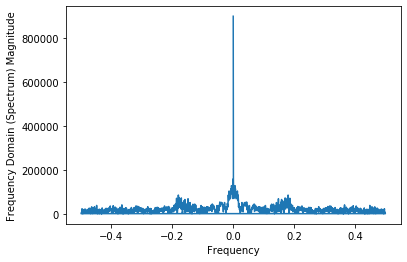

In [34]:
#Computing discrete fourier transform
fig, ax = plt.subplots()

X = fftpack.fft(count_list)
freqs = fftpack.fftfreq(len(count_list))

ax.set_xlabel('Frequency')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.plot(freqs, np.abs(X))
plt.show()

In [8]:
#Slicing data from beginning of 2020 to as much data as we have
#Getting all years that are in date list
unique_years = []
for date in date_list:
    if date.year not in unique_years:
        unique_years.append(date.year)

sliced_year_idxs = []
i, starting_idx = 0, 0
while i < len(unique_years):
    for idx, date in enumerate(date_list[starting_idx:]):
        if date.year == unique_years[i]:
            sliced_year_idxs.append(starting_idx + idx)
            i+= 1
            break
sliced_year_idxs.insert(len(sliced_year_idxs), len(date_list))

sliced_by_year = []
sliced_counts_by_year = []
for idx_1, idx_2 in zip(sliced_year_idxs[:-1], sliced_year_idxs[1:]):
    sliced_by_year.append(date_list[idx_1:idx_2])
    sliced_counts_by_year.append(count_list[idx_1:idx_2])
    
# Get rid of leap years
def find_closest(prev_year_lst, curr_year_lst, idx, years_ago):
    """ Given two lists and idx of date will return idx in prev_year_lst which is the closest to curr_year_lst[idx]
    but maintains the day of the week. Goes in the forward direction """
    
    curr_date = curr_year_lst[idx]
    prev_date = curr_date - relativedelta(years=years_ago)
    
    for idx, date in enumerate(prev_year_lst):
        if prev_date <= date:
            closest_date_idx = idx
            break
    
    for idx, date in enumerate(prev_year_lst[closest_date_idx:closest_date_idx + 5]):
        if date.weekday() == curr_date.weekday():
            return idx + closest_date_idx
    return None

yearly_sub_date_list, yearly_sub_count_list = [], []
for i, date in enumerate(sliced_by_year[-1]):
    nearest_idx = find_closest(sliced_by_year[0], sliced_by_year[-1], i, 1)
    if nearest_idx != None:
        sliced_counts_by_year[0][nearest_idx]
        yearly_sub_date_list.append(date)
        yearly_sub_count_list.append(sliced_counts_by_year[-1][i] - sliced_counts_by_year[0][nearest_idx])
        
fig, ax = plt.subplots(figsize=(8,6), dpi=300)
ax.plot(yearly_sub_date_list, yearly_sub_count_list)
            

UnboundLocalError: local variable 'closest_date_idx' referenced before assignment